In [1]:
from microstruktur.signal_models import spherical_mean_models
from microstruktur.core import modeling_framework
from microstruktur.signal_models.utils import (
    T1_tortuosity, parameter_equality
)
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

## Synthetic Experiment

In [2]:
from microstruktur.data import saved_acquisition_schemes, saved_data
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

In [3]:
stick_mean = spherical_mean_models.C1StickSphericalMean()
zeppelin_mean = spherical_mean_models.G4ZeppelinSphericalMean()

In [4]:
parameter_links_smt = [
    (  # tortuosity assumption
        zeppelin_mean, 'lambda_perp',
        T1_tortuosity, [
            (None, 'partial_volume_0'),
            (stick_mean, 'lambda_par')
        ]
    ),
    (  # equal parallel diffusivities
         zeppelin_mean, 'lambda_par',
         parameter_equality, [
            (stick_mean, 'lambda_par')
        ]
     )
]

In [5]:
mc_smt = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme,
    models=[stick_mean, zeppelin_mean],
    parameter_links=parameter_links_smt
)

In [6]:
results_mc_smt_multidif = mc_smt.fit(synthetic_data_parallel.signal_attenuation,
                                     Ns=5, use_parallel_processing=True)
results_mc_smt_multidif_dispersed = mc_smt.fit(synthetic_data_dispersed.signal_attenuation,
                                               Ns=5, use_parallel_processing=True)
# we separate the first one-third of the results that come from only D=1.7x10^-9 m/s^2 data
results_mc_smt_1_7, fractions_1_7 = (
    results_mc_smt_multidif[0: len(results_mc_smt_multidif) / 3],
    synthetic_data_parallel.fractions[0: len(results_mc_smt_multidif) / 3])
results_mc_smt_dispersed_1_7, fractions_1_7_dispersed = (
    results_mc_smt_multidif_dispersed[0: len(results_mc_smt_multidif_dispersed) / 3],
    synthetic_data_dispersed.fractions[0: len(results_mc_smt_multidif_dispersed) / 3])

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 1.68144202232 seconds.
Average of 0.00509527885553 seconds per voxel.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 14.4470579624 seconds.
Average of 0.00486432928028 seconds per voxel.


In [7]:
# estimating pearson correlation with ground truth
pr = pearsonr(results_mc_smt_1_7[:, -1], fractions_1_7)
pr_dispersed = pearsonr(results_mc_smt_dispersed_1_7[:, -1], fractions_1_7_dispersed)
pr_multidif = pearsonr(results_mc_smt_multidif[:, -1], synthetic_data_parallel.fractions)
pr_multidif_dispersed = pearsonr(results_mc_smt_multidif_dispersed[:, -1], synthetic_data_dispersed.fractions)

(0.2, 0.8)

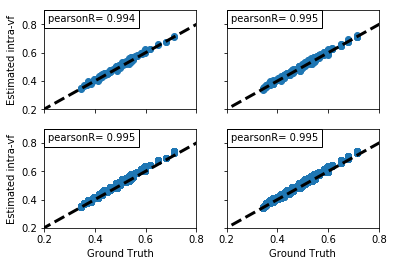

In [8]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.scatter(fractions_1_7, results_mc_smt_1_7[:, -1])
ax2.scatter(synthetic_data_parallel.fractions, results_mc_smt_multidif[:, -1])
ax3.scatter(fractions_1_7_dispersed, results_mc_smt_dispersed_1_7[:, -1])
ax4.scatter(synthetic_data_dispersed.fractions, results_mc_smt_multidif_dispersed[:, -1])

ax1.text(.216, .817, 'pearsonR= '+str(np.round(pr[0], 3)), fontsize=10, bbox=dict(facecolor='white', alpha=1))
ax2.text(.216, .817, 'pearsonR= '+str(np.round(pr_multidif[0], 3)), fontsize=10, bbox=dict(facecolor='white', alpha=1))
ax3.text(.216, .817, 'pearsonR= '+str(np.round(pr_dispersed[0], 3)), fontsize=10, bbox=dict(facecolor='white', alpha=1))
ax4.text(.216, .817, 'pearsonR= '+str(np.round(pr_multidif_dispersed[0], 3)), fontsize=10, bbox=dict(facecolor='white', alpha=1))

# ax1.set_title('Static Diffusivity')
ax3.set_xlabel('Ground Truth')
# ax2.set_title('Varying Diffusivity')
ax1.set_ylabel('Estimated intra-vf')
ax4.set_xlabel('Ground Truth')
ax3.set_ylabel('Estimated intra-vf')

ax1.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax2.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax3.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax4.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax1.set_ylim(0.2, .9)
ax1.set_xlim(0.2, .8)
ax4.set_ylim(0.2, .9)
ax4.set_xlim(0.2, .8)

# savefig('/user/rfick/home/Work/neuroimage_review/results_mcsmt.png', dpi=120)

## Real data example

In [9]:
from microstruktur.data import saved_data
data = saved_data.wu_minn_hcp_coronal_slice()

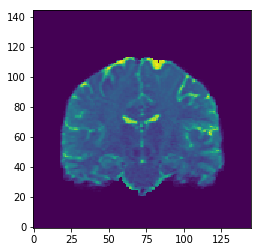

In [10]:
plt.imshow(data[:,0,:,0].T, origin=True)

In [11]:
fitted_parameter_vector_hcp = mc_smt.fit(data, mask=data[..., 0]>0, use_parallel_processing=True, Ns=10)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 65.9509439468 seconds.
Average of 0.00806147707454 seconds per voxel.


In [12]:
fitted_parameters = mc_smt.parameter_vector_to_parameters(fitted_parameter_vector_hcp)

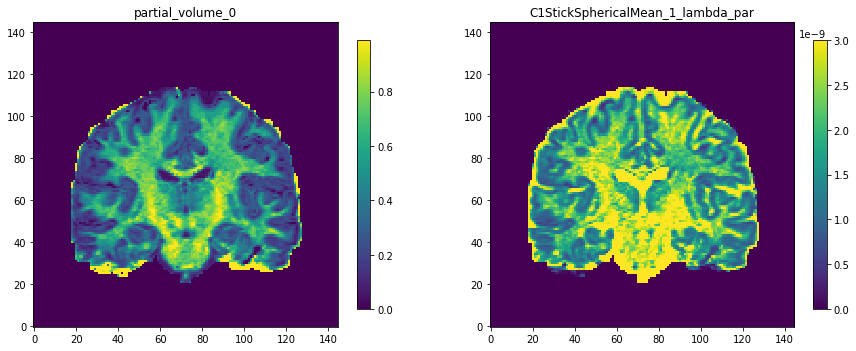

In [13]:
fig, axs = plt.subplots(1, len(fitted_parameters), figsize=[15, 15])
axs = axs.ravel()

for i, (name, values) in enumerate(fitted_parameters.items()):
    cf = axs[i].imshow(np.squeeze(values).T, origin=True)
    axs[i].set_title(name)
    fig.colorbar(cf, ax=axs[i], shrink=0.33)